# Exploratory Data Analysis (EDA) for Fraud Detection

## Dataset Overview

The dataset at hand encompasses financial transaction data, featuring essential attributes such as transaction details and a target variable denoted as `isFraud`. This target variable reflects the authentic fraud status of each transaction. Additionally, the dataset incorporates an indicator called `isFlaggedFraud`, utilized in a simulation to flag transactions based on predefined thresholds.

## Objective

The primary objective of this analysis is to enhance the fraud detection mechanism by refining the threshold used in the simulation. The emphasis lies in optimizing the criteria for identifying and capturing fraudulent transactions more effectively. Through a comprehensive Exploratory Data Analysis (EDA), we aim to derive valuable insights, patterns, and statistical summaries from the data, informing the formulation of an improved threshold strategy. This, in turn, contributes to the development of a more robust and accurate fraud detection system.

## 1- Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import plotly.graph_objs as go
import plotly.tools as tls

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2- Import Dataset

In [3]:
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
df.isnull().values.any()

False

In [5]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### a. Understanding the Data

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


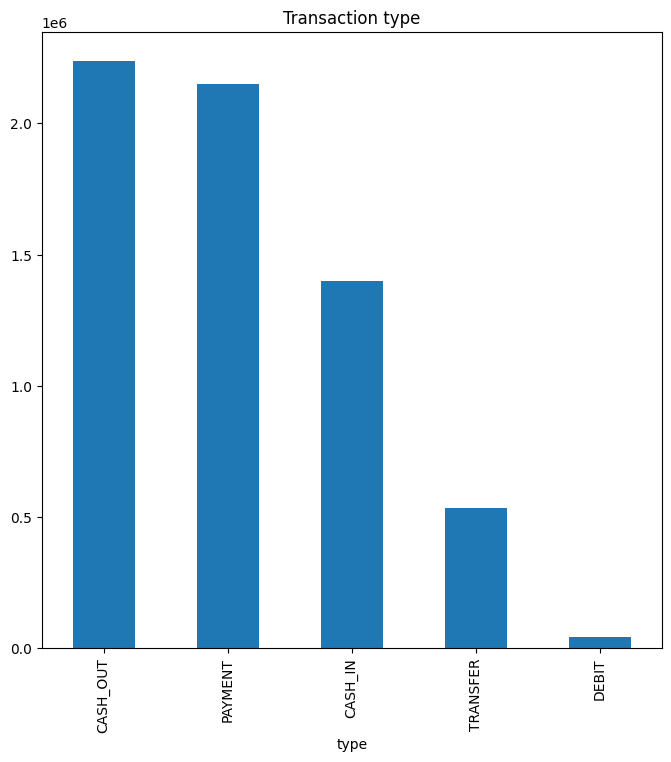

In [6]:
print(df.type.value_counts())

# Distribution of Transactions by Type
f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

#### b. Which types of Transactions are Fraudulent?*

In [7]:
df.groupby(['type', 'isFraud']).count()['step']

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: step, dtype: int64

In [8]:
# Distribution of Fraudulent transactions by Transaction Type

print('\nTypes of fraudulent transactions: {}'.format(\
", ".join(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\nNumber of Fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\nNumber of Fraudulent CASH OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


Types of fraudulent transactions: TRANSFER, CASH_OUT

Number of Fraudulent TRANSFERs = 4097

Number of Fraudulent CASH OUTs = 4116


Upon closer examination of the dataset, it becomes evident that fraudulent activities are concentrated within specific transaction types. Out of the five distinct transaction types, fraud is observed exclusively in two categories:

1. **TRANSFER:** Transactions falling under this category involve the transfer of funds to a customer or fraudster.
2. **CASH_OUT:** Transactions in this category entail the transfer of money to a merchant who subsequently pays the customer or fraudster in cash.

This observation aligns with the outlined modus operandi of fraudulent transactions as described on Kaggle. According to the dataset, it appears that fraudulent activities primarily involve the initial transfer of funds to another account, followed by a subsequent cash-out operation. This insight contributes to a deeper understanding of the patterns and dynamics surrounding fraudulent transactions within the dataset.

<Axes: xlabel='isFraud', ylabel='amount'>

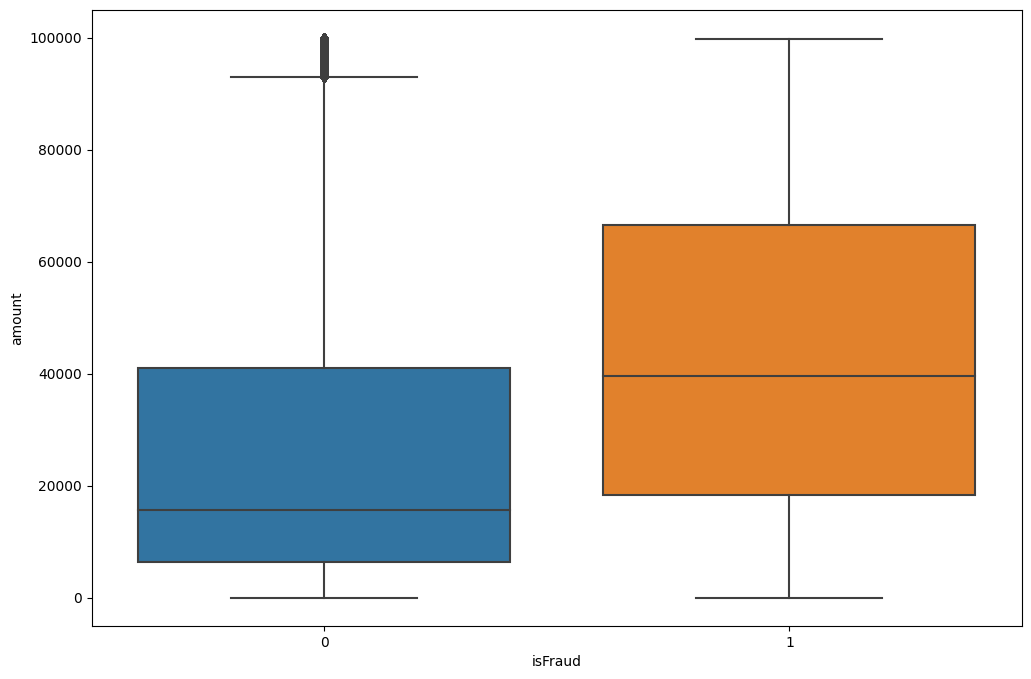

In [9]:
# Distribution of Transaction Amount among Fraudulent and Non-Fraudulent Transactions

plt.figure(figsize=(12,8))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

If we look at all Transactions, **Fraudulent** transactions tend to have larger amounts

But considering that **Fraudulent** transactions are only happening in **TRANSFER** and **CASH_OUT** Transaction types lets see the "amount distribution" among fraudulent and non-fraudulent transactions according to each transaction type. 

<Axes: xlabel='type', ylabel='amount'>

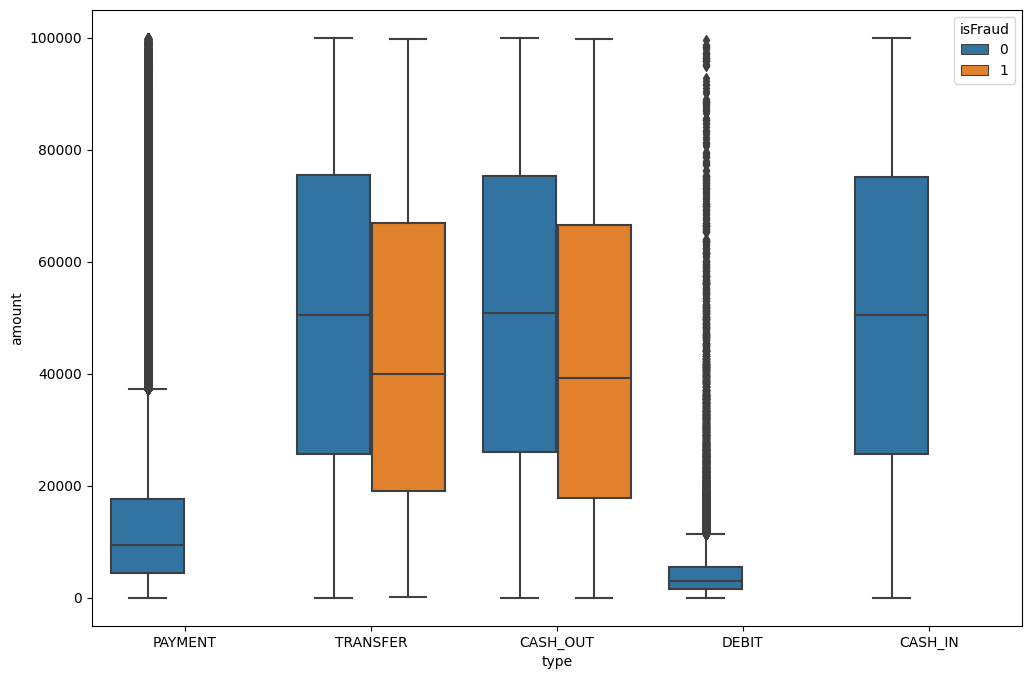

In [10]:
plt.figure(figsize=(12,8))
sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df[df.amount < 1e5])

Here we can see that in our main Transaction types **TRANSFER** and **CASH_OUT**, Fraudulent transactions tend to be in lesser amount than non-fraudulent transactions.

## 3- Data Cleaning

***Selection of Data for Analysis***

Based on the insights gained from the Exploratory Data Analysis (EDA), it is established that instances of fraud exclusively occur in two specific types of transactions: 'TRANSFER' and 'CASH_OUT'. Consequently, to focus our analysis on relevant data associated with fraudulent activities, we assemble a dedicated dataset denoted as `X`. This dataset encompasses only those transactions falling within the 'TRANSFER' and 'CASH_OUT' categories.

By narrowing down our analysis to these specific transaction types, we aim to derive targeted and meaningful patterns, features, and characteristics related to fraudulent transactions. This focused dataset, `X`, serves as a refined foundation for conducting a more detailed and precise examination of the factors influencing fraud within the context of the identified transaction categories.

In [11]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

# X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

***Dealing with missing values***

In [12]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nFraction of Fraudulent transactions with \'oldBalanceDest\' AND \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nFraction of Genuine transactions with \'oldBalanceDest\' AND \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


Fraction of Fraudulent transactions with 'oldBalanceDest' AND 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

Fraction of Genuine transactions with 'oldBalanceDest' AND newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Upon scrutiny of the dataset, it is notable that numerous transactions exhibit zero balances in the destination account both before and after a non-zero amount is transacted. This observation prompts further investigation, especially considering the potential significance of zero balances as an indicator.

Of particular interest is the discernible discrepancy in the occurrence of such transactions between fraudulent and genuine activities. Specifically:

- **Fraudulent Transactions:** Approximately 50% of fraudulent transactions exhibit zero balances in the destination account before and after a non-zero amount is transacted.
- **Genuine Transactions:** In contrast, a mere 0.06% of genuine transactions share the same characteristic.

This stark difference in the fraction of transactions with zero balances suggests a noteworthy pattern, with zero balances in the destination account potentially serving as an indicative factor for fraudulent activities. This insight prompts a deeper exploration into the role of zero balances in distinguishing between genuine and fraudulent transactions.

In [13]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

**Handling Destination Account Balances in Fraud Detection**

Given the significant indication that destination account balances being zero serves as a strong indicator of fraud, a strategic decision is made regarding the imputation of these balances before transactions occur. Imputing with statistics or distributions, followed by adjustments for the transaction amount, could potentially obscure this crucial fraud indicator. In such cases, fraudulent transactions might inadvertently appear genuine.

To address this, the following approach is adopted:

1. **Zero Balances Replacement:** Instead of traditional imputation methods, the value of 0 in destination account balances is replaced with -1.

This intentional replacement of zero balances with -1 is designed to preserve the distinctive nature of zero balances as a potential fraud indicator. The modified dataset, incorporating this adjustment, is envisioned to be more conducive to the effective functioning of a machine-learning (ML) algorithm tailored for fraud detection. By maintaining the integrity of zero balances as a distinct marker, the ML algorithm can leverage this information to more accurately identify and categorize instances of fraud.


In [14]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

**Analysis of Zero Balances in Originating Accounts**

A notable pattern within the dataset involves transactions wherein the originating account exhibits zero balances both before and after a non-zero amount is transacted. This observation prompts an in-depth analysis, particularly considering the differing prevalence of such transactions between fraudulent and genuine activities:

- **Fraudulent Transactions:** Approximately 0.3% of fraudulent transactions display zero balances in the originating account before and after a non-zero amount is transacted.
- **Genuine Transactions:** In contrast, a substantial 47% of genuine transactions exhibit the same characteristic.

Given the discrepancy in the occurrence of these transactions, similar to the approach adopted for destination account balances, a strategic decision is made regarding the imputation of zero balances in originating accounts:

1. **Zero Balances Replacement:** Rather than imputing a numerical value, the value of 0 in originating account balances is replaced with a null value.

This deliberate replacement aims to acknowledge the unique nature of zero balances as a potential distinguishing factor between genuine and fraudulent transactions. Null values are chosen to maintain transparency and allow machine-learning (ML) algorithms to interpret and utilize this feature effectively in the context of fraud detection.

## 4- Feature Engineering

In [15]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

**Error Indicators for Originating and Destination Accounts**

Building upon the insight that zero balances play a crucial role in distinguishing between fraudulent and genuine transactions, we extend our data-imputation strategy in the data cleaning section. In this advanced step, we introduce two new features (columns) designed to capture errors in both originating and destination accounts for each transaction.

The creation of these new features follows the logic that errors in account balances, particularly instances where zero balances are replaced, might serve as significant indicators of potential fraud. The two new features are as follows:

1. **Error in Originating Account (`error_in_origin`):** Records discrepancies or errors in originating account balances, highlighting instances where zero balances were replaced.

2. **Error in Destination Account (`error_in_destination`):** Captures discrepancies or errors in destination account balances, indicating instances where zero balances underwent replacement.

These newly introduced features have proven to be instrumental in achieving optimal performance from the machine-learning (ML) algorithm employed in the final stages. By incorporating these error indicators, the algorithm gains valuable insights into potential irregularities associated with account balances, contributing significantly to the enhanced detection of fraudulent transactions.

## 5- Data Visualisation

In [16]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x=x, y=y, hue = hue, jitter = 0.5, size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['Genuine', 'Fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

**Dispersion over Time**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_42/2595839313.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



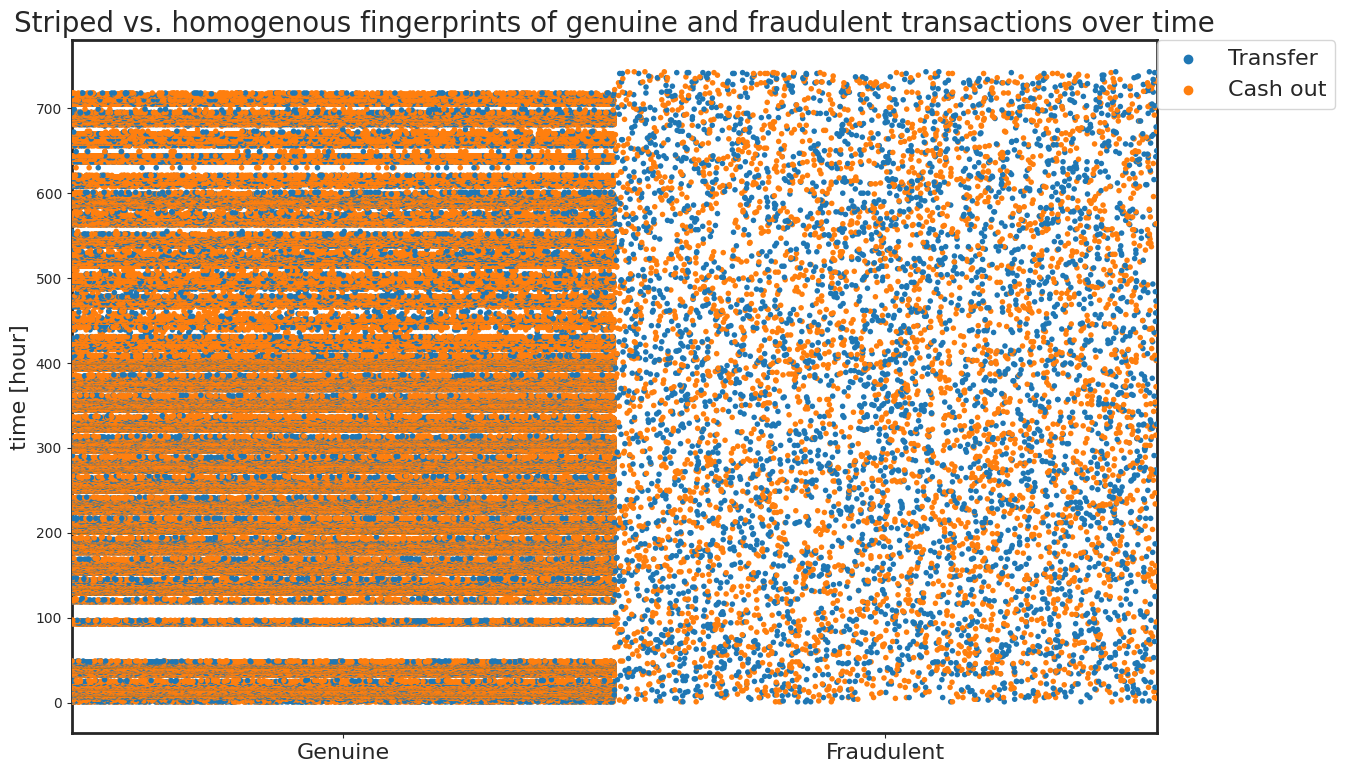

In [17]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

**Temporal Dispersion Analysis of Fraudulent and Genuine Transactions**

A comprehensive temporal analysis of fraudulent and genuine transactions reveals distinctive patterns that can be visualized through dispersion over time. The plotted data showcases unique fingerprints associated with each transaction type, providing valuable insights into their temporal distribution dynamics.

Key observations from the plot:

1. **Homogeneous Distribution of Fraudulent Transactions:** Fraudulent transactions exhibit a more homogenous distribution over time compared to genuine transactions. This distinctive pattern indicates a potentially synchronized occurrence of fraudulent activities.

2. **Disparity in CASH-OUT and TRANSFER Transactions:** Notably, genuine transactions feature a higher prevalence of CASH-OUTs compared to TRANSFERs. In contrast, fraudulent transactions demonstrate a more balanced distribution between CASH-OUTs and TRANSFERs.

It's important to highlight that the width of each 'fingerprint' in the plot is influenced by the 'jitter' parameter in the `plotStrip` function. This parameter aims to separate and visually represent transactions occurring simultaneously with different abscissae. The resulting visualizations offer a nuanced perspective on the temporal characteristics of fraudulent and genuine transactions, paving the way for deeper insights into their temporal behavior.

**Dispersion Over Amount**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_42/2595839313.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



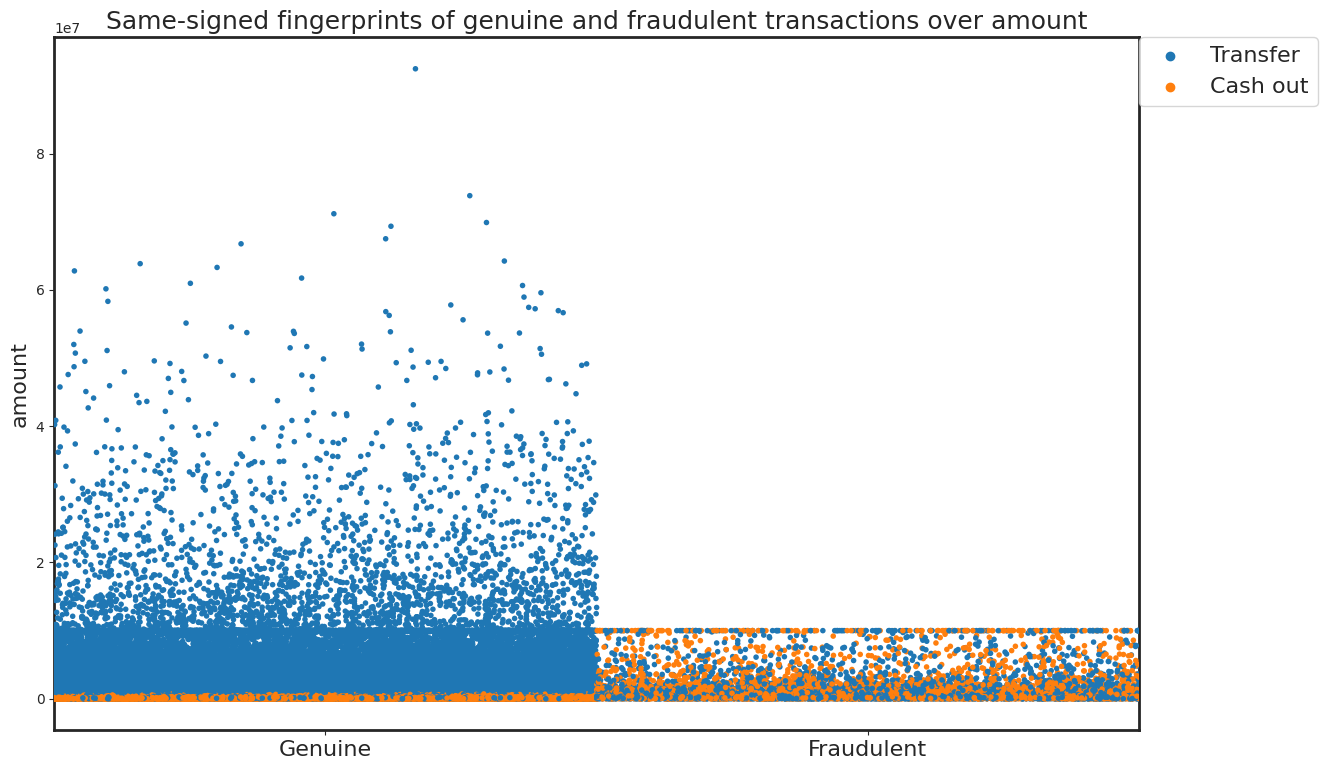

In [18]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

**Comparative Analysis: Original Amount vs. New Error Balance in Destination**

A comparative analysis is conducted to evaluate the effectiveness of distinguishing fraudulent transactions based on two distinct features: the original amount and the newly introduced `errorBalanceDest` feature.

Key findings from the analysis:

1. **Original Amount Feature:** The presence of fraud in a transaction can be discerned to some extent through the original amount feature. However, its effectiveness in making a clear distinction is limited.

2. **New Feature: Error Balance in Destination (`errorBalanceDest`):** In contrast, the newly engineered `errorBalanceDest` feature proves to be more effective at distinguishing fraudulent transactions. This novel feature, capturing errors in destination account balances, emerges as a more potent indicator of potential fraud compared to the original amount.

These observations emphasize the significance of feature engineering and the strategic creation of new features in enhancing the discriminatory power of machine-learning algorithms. The `errorBalanceDest` feature, tailored to specific characteristics of the data, emerges as a valuable asset for improving the detection accuracy of fraudulent transactions.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:200: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/tmp/ipykernel_42/2595839313.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



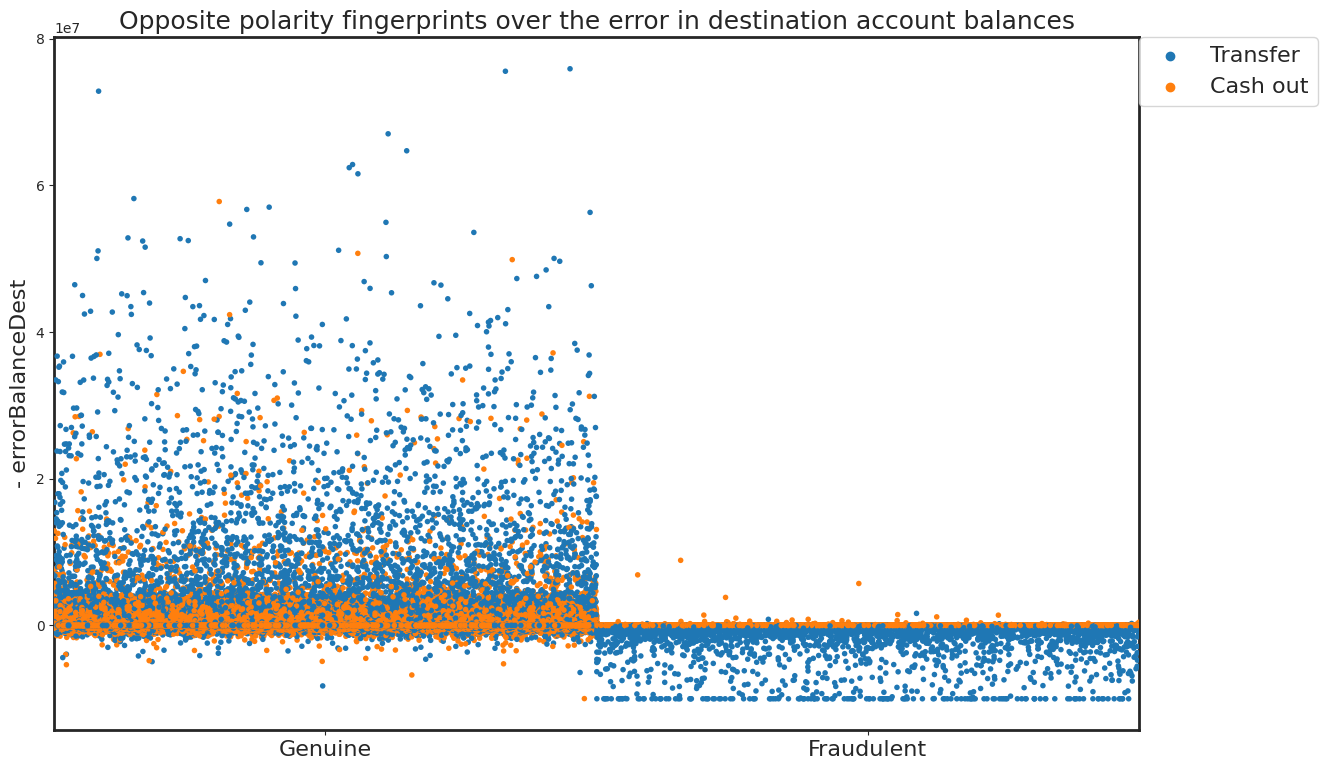

In [19]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

**Separating Genuine and Fraudulent Transactions in 3D**

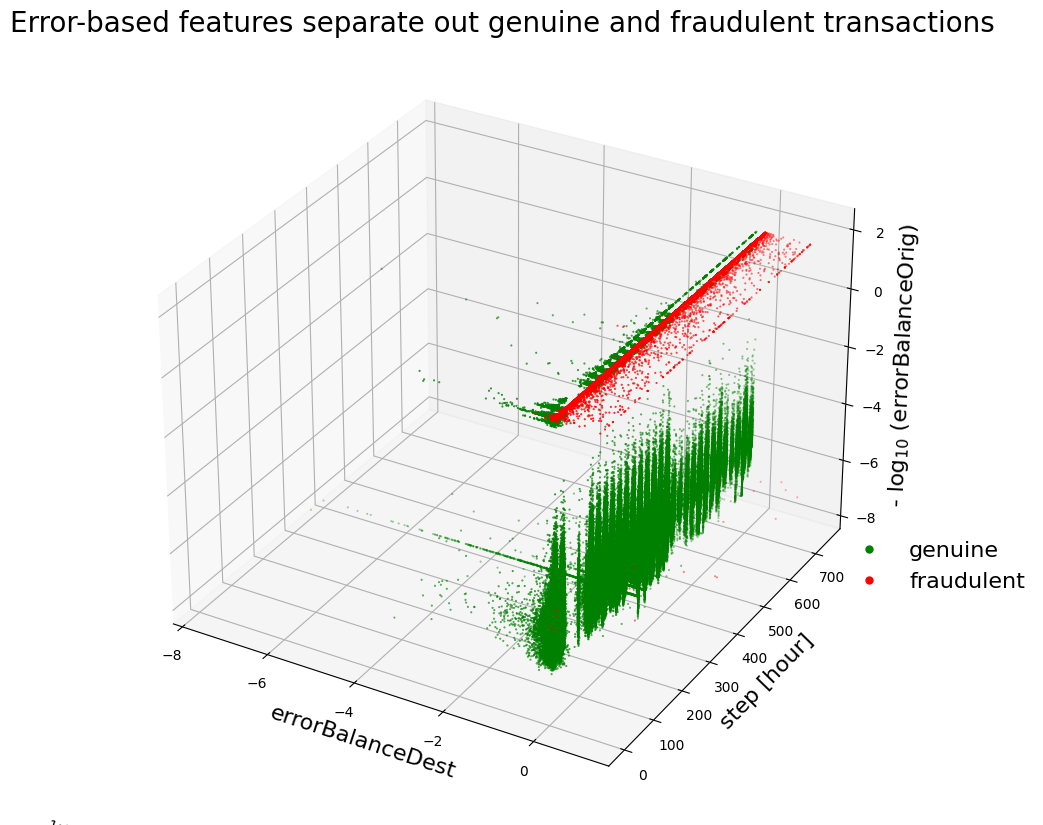

In [20]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

The three-dimensional (3D) plot is employed to discern and distinguish between fraudulent and non-fraudulent data, leveraging both of the engineered error-based features. This advanced visualization strategy provides a holistic view that incorporates the complexities introduced by multiple features.

Key insights from the 3D plot:

1. **Effectiveness of Engineered Error-Based Features:** The plot demonstrates that the combination of the two engineered error-based features (e.g., `error_in_origin` and `errorBalanceDest`) contributes significantly to the optimal separation of fraud and non-fraud data. These features, designed to capture discrepancies and errors in account balances, emerge as potent discriminators for fraudulent transactions.

2. **Ineffectiveness of Original Step Feature:** In contrast, the original step feature proves to be ineffective in clearly distinguishing fraudulent transactions. The limitations of this feature become apparent in the context of the richer and more informative engineered features.

3. **Anticipated Striped Nature of Genuine Data vs. Time:** Notably, the striped nature of genuine data over time, as anticipated from the dispersion visualization, is confirmed in the 3D plot. This observation aligns with the expected temporal behavior of genuine transactions.

This multidimensional analysis underscores the importance of feature engineering in uncovering nuanced patterns within the data. The engineered error-based features, when visualized in three dimensions, emerge as powerful tools for enhancing the separation and detection of fraudulent transactions.


**Difference between Fingerprints of Fraudulent and Non-fraudulent transactions**

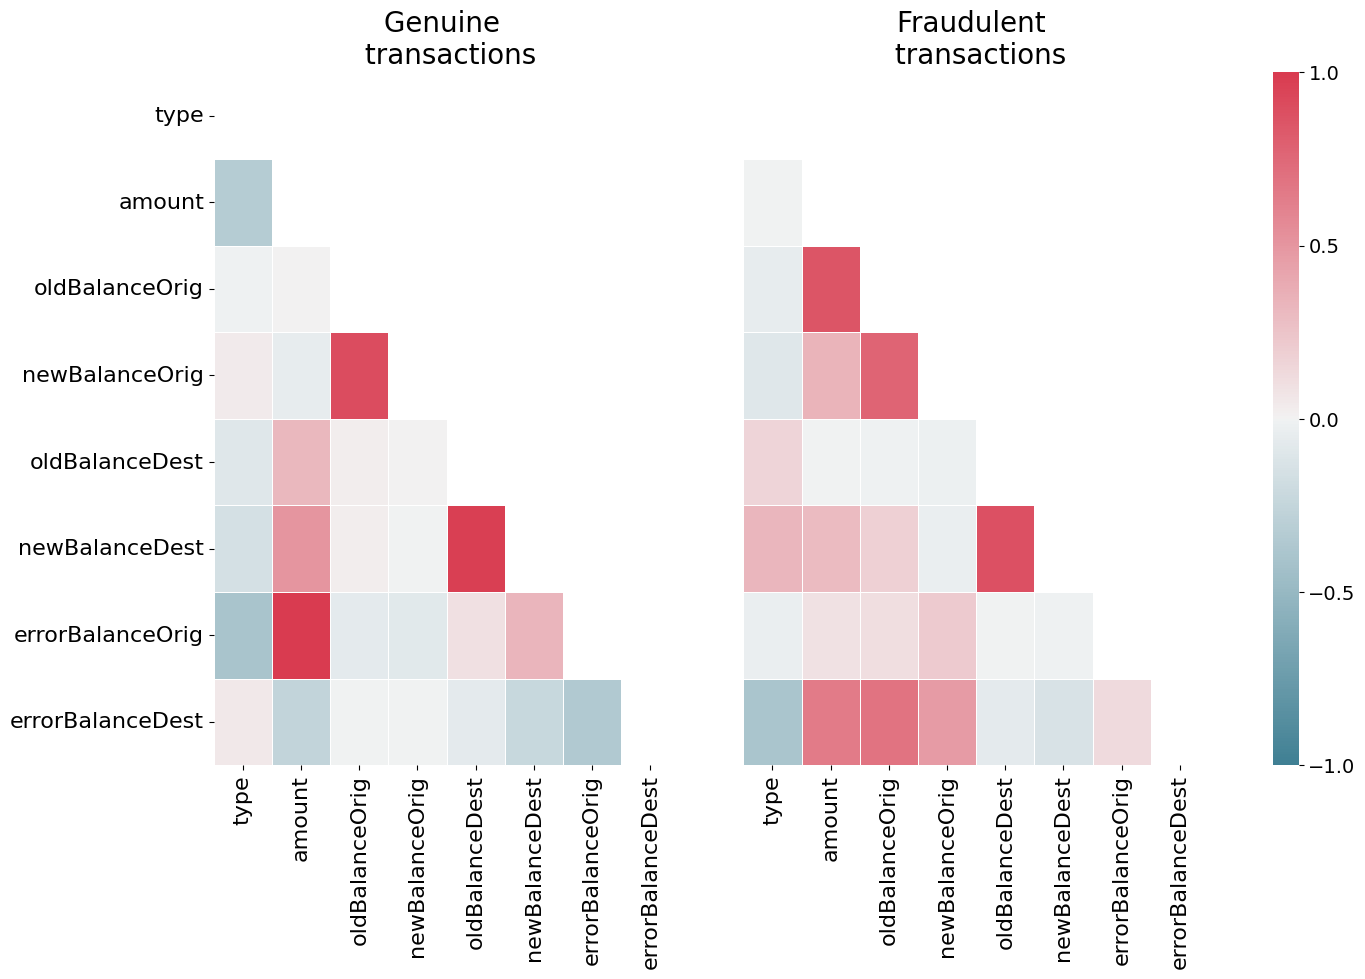

In [21]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

A detailed examination of the dataset reveals compelling evidence, akin to a "smoking gun," highlighting the stark differences between fraudulent and genuine transactions. This evidence is unearthed through the exploration of correlations, as depicted in the heatmaps below.

Key insights from the heatmaps:

1. **Fraudulent Transactions Heatmap:** The heatmap dedicated to fraudulent transactions unravels distinct correlation patterns unique to fraudulent activities. Specific features exhibit strong correlations or anticorrelations, offering valuable clues about the inherent characteristics of fraudulent transactions.

2. **Genuine Transactions Heatmap:** Conversely, the heatmap representing genuine transactions showcases its own set of correlation dynamics. The correlation patterns in genuine transactions differ significantly from those observed in fraudulent transactions, underscoring the dissimilarity between the two categories.

3. **Comprehensive Evidence:** The heatmaps collectively provide comprehensive evidence, laying bare the intricate relationships and dependencies within each transaction type. This analytical approach serves as a powerful tool for extracting valuable information and understanding the nuanced features that contribute to the differentiation between fraudulent and genuine transactions.

The visual representation of correlations through heatmaps serves as a compelling and intuitive method for unraveling the distinct fingerprints embedded in the dataset, ultimately contributing to a more profound comprehension of the underlying dynamics of fraudulent and genuine transactions.

# Machine Learning for Fraud Detection in Skewed Data

Building upon the insights derived from the aforementioned plots, which reveal the presence of features facilitating the clear detection of fraudulent transactions, the subsequent challenge lies in training a robust machine-learning (ML) model. However, a significant hurdle emerges due to the highly imbalanced nature of the dataset.

Key considerations:

1. **Evident Features for Fraud Detection:** The plots affirm that the dataset now encompasses features that enhance the detectability of fraudulent transactions. These engineered features, derived from careful analysis and data manipulation, contribute to creating a more discernible distinction between fraudulent and genuine activities.

2. **Imbalanced Nature of the Data:** Despite the enhanced features, the data remains highly imbalanced, with a notable disproportion between the number of fraudulent and genuine transactions. This imbalance poses a challenge for training a reliable ML model, as the model might be biased toward the majority class (genuine transactions) and struggle to effectively identify instances of fraud.

Addressing the imbalance in the data is a crucial step toward building a robust and effective ML model for fraud detection. Various techniques, such as resampling, ensemble methods, and specific algorithms designed for imbalanced datasets, can be explored to mitigate the impact of this imbalance and improve the model's performance in accurately identifying and classifying fraudulent transactions.

In [22]:
print('Skewness of data = {}'.format( len(Xfraud) / float(len(X)) ))

Skewness of data = 0.002964544224336551


# Selection of Metrics and ML Algorithm for Fraud Detection

## Metric Selection:

Given the highly skewed nature of the data, a meticulous choice of evaluation metric is paramount. Instead of relying on the conventional area under the receiver operating characteristic (AUROC) curve, the area under the precision-recall curve (AUPRC) is selected. This decision is grounded in the sensitivity of AUPRC to differences between algorithms and their parameter settings, making it more apt for imbalanced datasets (refer to Davis and Goadrich, 2006).

## ML Algorithm Selection:

### Handling Imbalanced Data:

A primary strategy for addressing imbalanced data involves choosing an appropriate ML algorithm. Initial attempts often include discarding the majority class through undersampling, but this comes at the cost of information loss. A more effective approach involves oversampling the minority class, with Synthetic Minority Over-sampling Technique (SMOTE) being a notable technique available in the 'imblearn' library.

### Experimentation with Anomaly Detection and Supervised Learning:

Motivated by the need to tackle imbalanced data, various approaches, including anomaly detection and supervised learning techniques, are explored. However, it is discovered that the most favorable outcome is achieved by leveraging an ML algorithm based on ensembles of decision trees. These algorithms inherently perform well on imbalanced data, allowing for effective handling of missing values in the dataset. Additionally, they facilitate parallel processing for improved speed.

### Optimal ML Algorithm: Extreme Gradient-Boosted (XGBoost)

Among the ensemble-based algorithms, the extreme gradient-boosted (XGBoost) algorithm outperforms others, including the random forest. XGBoost not only excels in constructing models resilient to imbalanced data but also accommodates the weighting of the positive class, offering a means to address the skew in the data. This flexibility, coupled with its capacity for parallel processing, makes XGBoost the optimal choice for achieving superior results on the original dataset.

*Split data in 80:20 Ratio*

In [23]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [24]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.9926360768575739


<Figure size 800x600 with 0 Axes>

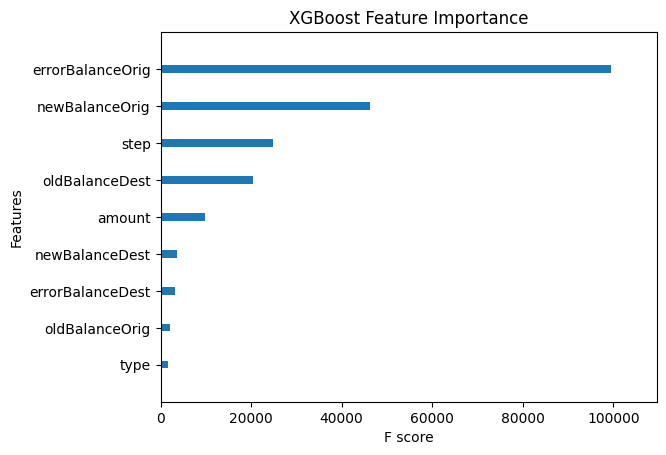

In [25]:
# Plot feature importance for XGBoost
plt.figure(figsize=(8, 6))
plot_importance(booster=clf, grid = False, \
                     show_values = False, importance_type = 'cover')
plt.title('XGBoost Feature Importance')
plt.show()

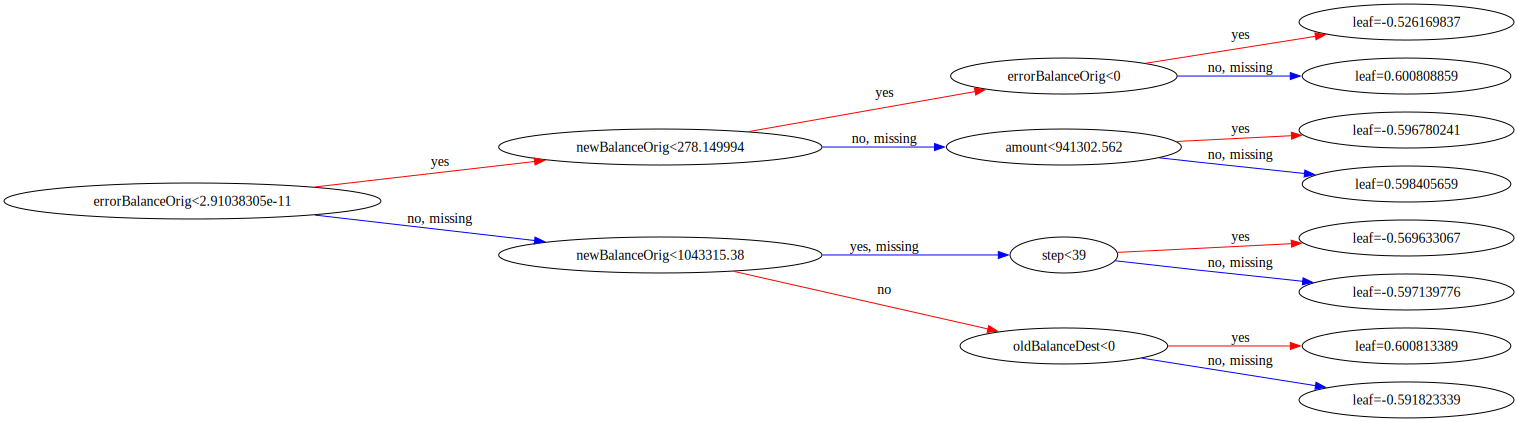

In [26]:
to_graphviz(clf,  rankdir='LR')